
# Lab 1 — Car Mileage Estimation (Regression) — 

This version includes:
- A **version‑agnostic** `OneHotEncoder` (works across different scikit‑learn releases)
- A **single, minimal working block** that defines `X_train, X_test, y_train, y_test` and computes metrics in one place
- A **manual RMSE** computation (compatible with older sklearn without `squared=False`)

> **Expected input**: `cars.csv` with numeric target column **`target_mileage`** and mixed numeric/categorical features (e.g., `engine_size`, `cylinders`, `weight`, `horsepower`, `transmission`, `fuel_type`, …).



## Learning Outcomes
- Explain what **regression** is and when to use it.
- Prepare data with **imputation**, **scaling**, and **one‑hot encoding** using `ColumnTransformer` and `Pipeline`.
- Train and evaluate a **Random Forest Regressor**.
- Interpret model performance with **MAE**, **RMSE**, **R²** and visualize **residuals** and **feature importance**.
- Save and reuse the trained pipeline for inference.



## 1) Setup (optional)
If needed, install dependencies. Skip if already available.


In [4]:

# !pip install -q pandas numpy scikit-learn matplotlib seaborn joblib



## 2) Imports & Configuration


In [5]:

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

sns.set(style="whitegrid", context="notebook")

DATA_PATH = "data/cars.csv"
TARGET_COL = "target_mileage"
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_JOBS = -1

import sklearn
print("scikit-learn:", sklearn.__version__)


scikit-learn: 1.7.2



## 3) Load Data


In [6]:

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset '{DATA_PATH}' not found. Place it next to this notebook.")

df = pd.read_csv(DATA_PATH)
assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not in columns: {list(df.columns)}"

# Ensure numeric target
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

print(df.shape)
df.head()


(10000, 27)


,brand,model,year,body_type,engine_size,cylinders,turbo,horsepower,torque_nm,weight,...,fuel_type,drivetrain,odometer_km,city_ratio,battery_kwh,emission_std,co2_gpkm,l_per_100km,price,target_mileage
0,Toyota,RAV4,2005,crossover,1.76,4,0,141.0,254,1761.0,...,hybrid,FWD,358819.0,0.460,2.08,EURO 4,89.7,4.48,9373,22.30
1,Honda,CR-V,2011,hatchback,1.94,4,1,186.0,300,1414.0,...,petrol,FWD,345848.0,0.366,0.00,EURO 5,125.3,5.24,16127,19.10
2,Nissan,Rogue,2021,crossover,1.79,4,1,190.0,344,1890.0,...,hybrid,FWD,75509.0,0.495,1.55,EURO 6d,83.7,4.18,22381,23.90
3,Chevrolet,Equinox,2023,sedan,2.10,4,0,168.0,248,1637.0,...,diesel,FWD,48220.0,0.613,0.00,EURO 6d,116.4,4.41,30606,22.67
4,Kia,Rio,2012,crossover,1.76,4,1,204.0,331,1995.0,...,petrol,FWD,198178.0,0.544,0.00,EURO 5,171.0,7.15,17558,13.99



### (Optional) Quick EDA


In [7]:

# Missing values per column
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing>0])

# Basic stats for numeric features
df.select_dtypes(include=np.number).describe().T.head(10)


engine_size     200
horsepower      100
weight          100
co2_gpkm        100
transmission    100
fuel_type        60
odometer_km      50
dtype: int64

,count,mean,std,min,25%,50%,75%,max
year,10000.0,2015.636100,5.655924,2005.0,2011.00,2016.0,2021.00,2024.0
engine_size,9800.0,2.578062,1.246549,0.8,1.64,2.3,3.23,6.5
cylinders,10000.0,5.724900,2.237972,3.0,4.00,6.0,8.00,12.0
turbo,10000.0,0.397700,0.489447,0.0,0.00,0.0,1.00,1.0
horsepower,9900.0,225.016061,86.990162,58.0,163.00,206.0,267.00,650.0
torque_nm,10000.0,372.863500,150.980244,80.0,264.00,339.0,451.00,1000.0
weight,9900.0,1901.616061,376.324389,1139.0,1624.00,1858.5,2121.00,3200.0
wheelbase_mm,10000.0,2720.641500,158.998476,2423.0,2601.00,2689.0,2809.00,3200.0
length_mm,10000.0,4608.018300,333.890434,3995.0,4357.00,4546.0,4795.00,5600.0
width_mm,10000.0,1846.079000,79.114602,1685.0,1786.00,1833.0,1892.00,2050.0



## 4) Train/Test Split, Preprocess & Train (Single Working Block)
This cell defines all variables (`X_train`, `X_test`, `y_train`, `y_test`, `pipe`) and trains the model.


In [8]:

from sklearn.preprocessing import FunctionTransformer

# Split X/y
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

# Identify column types
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Version-agnostic OHE factory
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe = make_ohe()

# Build pipelines
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_steps = [
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
]

# If OHE returns sparse, densify
returns_sparse = getattr(ohe, "sparse", None) is True or getattr(ohe, "sparse_output", None) is True
if returns_sparse or (getattr(ohe, "sparse", None) is None and getattr(ohe, "sparse_output", None) is None):
    cat_steps.append(("to_dense", FunctionTransformer(lambda X: X.toarray(), accept_sparse=True)))

cat_pipe = Pipeline(cat_steps)

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
])

model = RandomForestRegressor(n_estimators=350, random_state=RANDOM_STATE, n_jobs=N_JOBS)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", model)
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Fit pipeline
pipe.fit(X_train, y_train)

print("Done. Variables defined: X_train, X_test, y_train, y_test, pipe")


Done. Variables defined: X_train, X_test, y_train, y_test, pipe



## 5) Evaluate (MAE, RMSE, R²) — Version‑Agnostic


In [9]:

# Guard rails
try:
    _ = (y_test, pipe)
except NameError as e:
    raise RuntimeError("Make sure you ran the previous cell that defines X_train/X_test/y_train/y_test/pipe.") from e

# Predict
y_pred = pipe.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # manual RMSE for compatibility
r2 = r2_score(y_test, y_pred)

print(f"Test MAE : {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R^2 : {r2:.4f}")

# Cross-validation on TRAIN only
cv_scores = cross_val_score(
    pipe, X_train, y_train, scoring="neg_mean_absolute_error", cv=5, n_jobs=N_JOBS
)
print(f"CV MAE (5-fold on train): {-cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


Test MAE : 0.017
Test RMSE: 0.144
Test R^2 : 0.9997
CV MAE (5-fold on train): 0.015 ± 0.002



## 6) Diagnostic: Residuals vs Predicted


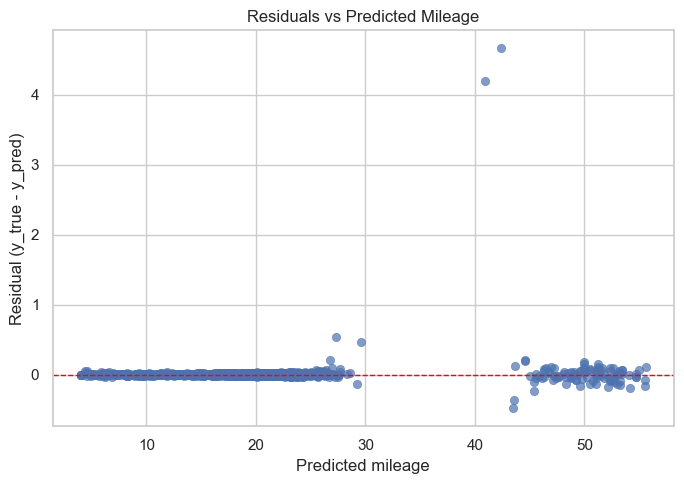

In [10]:

resid = y_test - y_pred
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_pred, y=resid, alpha=0.7, edgecolor=None)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs Predicted Mileage')
plt.xlabel('Predicted mileage')
plt.ylabel('Residual (y_true - y_pred)')
plt.tight_layout()
plt.show()



## 7) Interpretability: Feature Importance


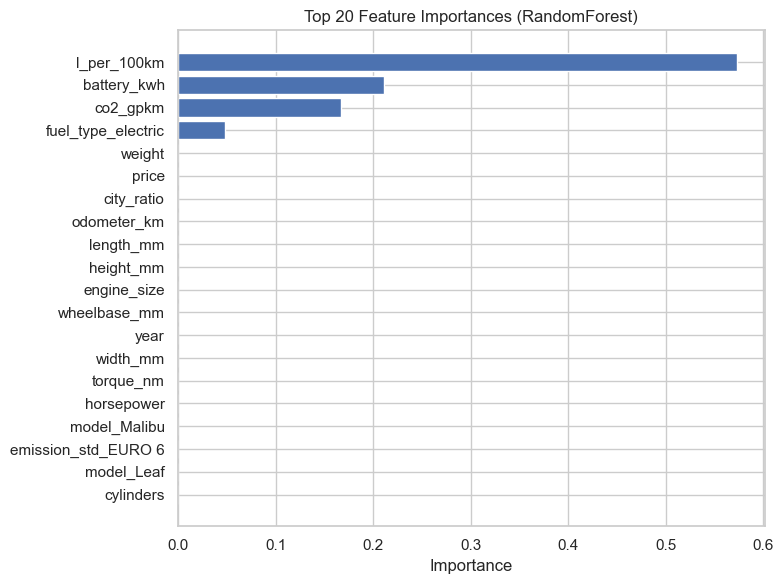

In [11]:

# Recover fitted parts
fitted_pre = pipe.named_steps["preprocess"]
rf = pipe.named_steps["model"]

# Build feature names
num_cols_fitted = fitted_pre.transformers_[0][2] if fitted_pre.transformers_ else []
cat_cols_fitted = fitted_pre.transformers_[1][2] if len(fitted_pre.transformers_) > 1 else []

try:
    ohe_fitted = fitted_pre.named_transformers_["cat"].named_steps["ohe"]
    cat_feature_names = ohe_fitted.get_feature_names_out(cat_cols_fitted)
    feature_names = list(num_cols_fitted) + list(cat_feature_names)
except Exception:
    feature_names = [f"feat_{i}" for i in range(len(rf.feature_importances_))]

importances = np.array(rf.feature_importances_)
idx = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[idx][::-1], importances[idx][::-1])
plt.title("Top 20 Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()



## 8) Save Trained Pipeline


In [12]:

joblib.dump(pipe, "mileage_model.pkl")
print("Saved → mileage_model.pkl")


Saved → mileage_model.pkl
